# **Clasificación de imágenes con Redes Neuronales Convolucionales (CNN)**
---

## Objetivos

- Desarrollar y entrenar distintos modelos de redes neuronales convolucionales capaces de clasificar con la mayor exactitud posible las imágenes del conjunto de datos CIFAR-10.
- Comparar el rendimiento de varios enfoques:
  - Un modelo básico sin técnicas avanzadas de normalización o regularización.
  - Un modelo más profundo y regularizado con Batch Normalization y L2.
  - Un modelo superior que, además de contar con las técnicas anteriores, incorpora data augmentation y un learning rate scheduler.
- Analizar el impacto de cada técnica utilizada en la precisión y en la capacidad de generalización del modelo.
- Documentar los resultados, las mejores configuraciones obtenidas y las conclusiones derivadas de cada experimento.

---

## Descripción del proyecto

Este proyecto se centra en la clasificación de imágenes. A lo largo del proyecto, se exploran distintas arquitecturas de redes neuronales convolucionales y técnicas de regularización para mejorar la precisión en la clasificación. El dataset a utilizar consiste en 60000 imágenes a color de 10 clases de animales y vehículos. El dataset en cuestión se denomina [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Los animales y vehículos pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros animales/vehículos en pantalla (el elemento a clasificar siempre aparece en la posición predominante).

Las CNN profundas son un tipo de modelo avanzado y computacionalmente costoso, se recomienda usar Google Colaboratory con soporte para GPUs si el equipo tarda demasiado en los entrenamientos. 

En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. 

*Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usará la librería opencv. Esta librería está ya instalada en el entorno de Colab, pero si trabajas de manera local tendrás que instalarla.*

<center><img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png" style="text-align: center" height="300px"></center>

---

## **Carga de los datos**

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import keras.datasets.cifar10 as cifar10

from tensorflow import keras
from keras.utils import to_categorical

In [ ]:
# Se definen los datos de entrenamiento, validación y test
(X, Y), (x_test, y_test) = cifar10.load_data()
(x_train, x_valid) = (X[:40000], X[40000:])
(y_train, y_valid) = (Y[:40000], Y[40000:])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Normalizo los datos de entrada para que estén entre 0 y 1
x_train = x_train / 255.
x_valid = x_valid / 255.
x_test = x_test / 255.

In [ ]:
# Mapeo de número de clase a elemento (animal o vehículo) correspondiente en CIFAR-10
MAP_ELEMENTS = {
    0: 'avion', 1: 'coche', 2: 'ave',
    3: 'gato', 4: 'ciervo', 5: 'perro', 6: 'rana',
    7: 'caballo', 8: 'barco', 9: 'camion'
}

In [ ]:
# Función para convertir las etiquetas a codificación one-hot (vector de 10 elementos)
def convert_to_one_hot(labels, num_classes):
    return np.squeeze(np.array([to_categorical(label, num_classes=num_classes) for label in labels]))

# Convierto las etiquetas de entrenamiento, validación y test a codificación one-hot
num_classes = 10
y_train_one_hot = convert_to_one_hot(y_train, num_classes)
y_valid_one_hot = convert_to_one_hot(y_valid, num_classes)
y_test_one_hot = convert_to_one_hot(y_test, num_classes)

# Verifico las conversiones
print(y_train_one_hot.shape)
print(y_valid_one_hot.shape)
print(y_test_one_hot.shape)

(40000, 10)
(10000, 10)
(10000, 10)


## **Visualización del dataset CIFAR-10**

Mostraré algunas imágenes del dataset con sus etiquetas para entender mejor los datos.

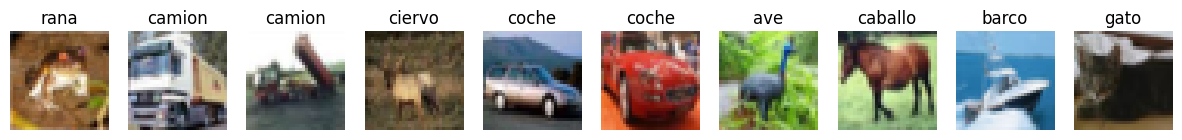

In [ ]:
# Función para mostrar imágenes con etiquetas
def plot_images(images, labels, class_names, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(class_names[labels[i][0]])
        ax.axis("off")
    plt.show()

# Mostrar 10 imágenes aleatorias del conjunto de entrenamiento
plot_images(X[:10], Y[:10], MAP_ELEMENTS)

Podemos ver 10 ejemplos extraídos del conjunto de entrenamiento del dataset con su etiqueta asociada. Como se indica en la descripción, este conjunto está compuesto por clases que incluyen tanto animales como vehículos. De esta forma podemos observar la diversidad y complejidad de las imágenes, ya que cada clase tiene variaciones en cuanto a poses, ángulos, iluminación y fondo.

## **CNN básica**

Empezaré por un modelo básico de CNN para realizar un primer análisis y establecer una línea base de rendimiento. Este diseño lo ajustará en iteraciones posteriores.

Se usarán siguientes técnicas para la arquitectura del modelo:
- Dropout
- Adam
- Learning rate de 0.001
- 50 epochs

### **Definición del modelo**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def cnn_inicial(input_shape=(32, 32, 3), num_classes=10): # Espero recibir imágenes 32x32 con 3 canales RGB y 10 clases
    model = Sequential([

        # Primera capa de 32 neuronas
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape), # Padding='same' para mantener el tamaño de la imagen de entrada
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Segunda capa de 64 neuronas
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Tercera capa de 128 neuronas
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(), # Aplana la salida de la última capa para poder conectarla a una capa full connected

        Dense(128, activation='relu'),           # Capa full connected con 128 neuronas
        Dropout(0.5),                            # Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento para prevenir overfitting y mejorar la generalización.

        Dense(num_classes, activation='softmax') # Capa de salida con 10 neuronas y función de activación softmax
    ])
    return model

model = cnn_inicial() # Creo el modelo
model.summary()       # Muestro el resumen del modelo


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

### **Compilación y entrenamiento**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compilo el modelo (Optimizador Adam)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Defino callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)           # Para detener el entrenamiento si hay 10 epochs sin mejoras
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)    # Guardo el mejor modelo durante el entrenamiento

# Entreno el modelo
history = model.fit(x_train, y_train_one_hot,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_valid, y_valid_one_hot),
                    callbacks=[early_stop, checkpoint])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.2419 - loss: 2.0273 - val_accuracy: 0.4689 - val_loss: 1.5023
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4474 - loss: 1.5101 - val_accuracy: 0.5479 - val_loss: 1.2380
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5147 - loss: 1.3481 - val_accuracy: 0.6035 - val_loss: 1.1104
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5598 - loss: 1.2343 - val_accuracy: 0.6404 - val_loss: 1.0480
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5906 - loss: 1.1590 - val_accuracy: 0.6652 - val_loss: 0.9693
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6153 - loss: 1.0995 - val_accuracy: 0.6725 - val_loss: 0.9267
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6265 - loss: 1.0534 - val_accuracy: 0.6893 - val_loss: 0.8837
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6474 - loss: 1.0014 - val_accuracy: 

### **Gráficas de precisión y pérdida durante el entrenamiento**

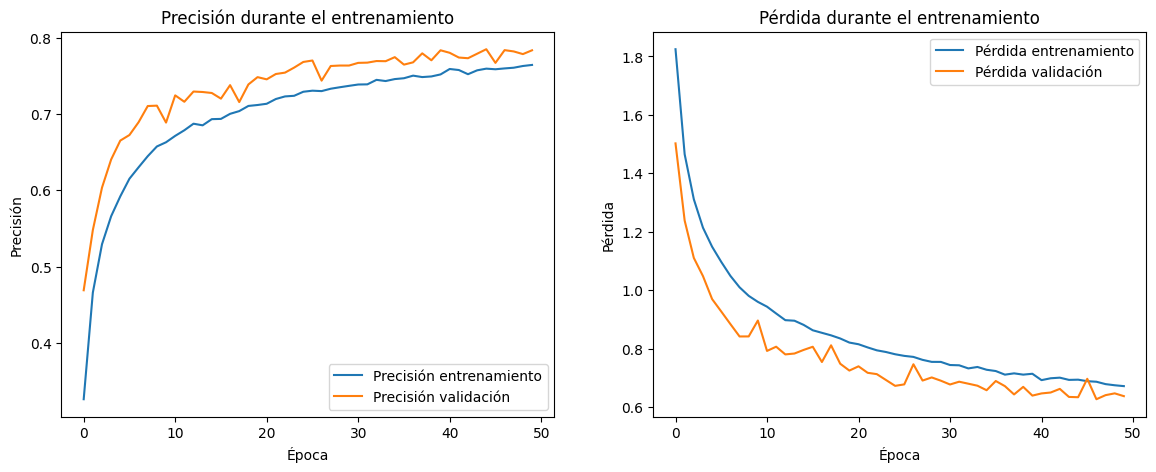

In [ ]:
#Gráfica de precisión y pérdida durante el entrenamiento
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))

    #Precisión
    axs[0].plot(history.history['accuracy'], label='Precisión entrenamiento')
    axs[0].plot(history.history['val_accuracy'], label='Precisión validación')
    axs[0].set_title('Precisión durante el entrenamiento')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()

    #Pérdida
    axs[1].plot(history.history['loss'], label='Pérdida entrenamiento')
    axs[1].plot(history.history['val_loss'], label='Pérdida validación')
    axs[1].set_title('Pérdida durante el entrenamiento')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Pérdida')
    axs[1].legend()

    plt.show()

plot_training_history(history)


Se observa una convergencia estable, con una pérdida que disminuye de manera constante y una precisión que aumenta progresivamente.

La pérdida del conjunto de validación se estabiliza alrededor del final del entrenamiento, lo que indica que el modelo podría beneficiarse de ajustes en la regularización.

### **Análisis de resultados**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


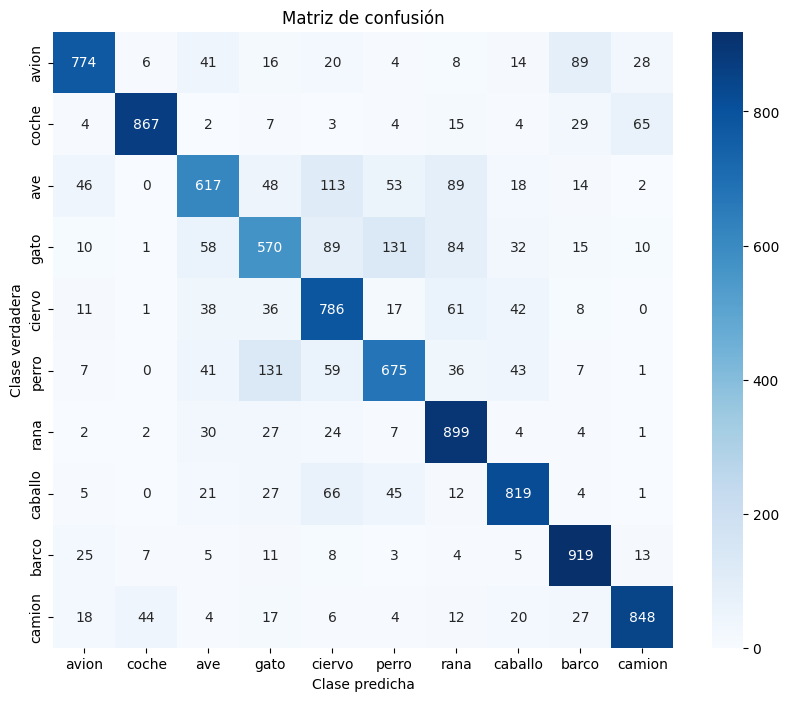

              precision    recall  f1-score   support

       avion       0.86      0.77      0.81      1000
       coche       0.93      0.87      0.90      1000
         ave       0.72      0.62      0.66      1000
        gato       0.64      0.57      0.60      1000
      ciervo       0.67      0.79      0.72      1000
       perro       0.72      0.68      0.69      1000
        rana       0.74      0.90      0.81      1000
     caballo       0.82      0.82      0.82      1000
       barco       0.82      0.92      0.87      1000
      camion       0.88      0.85      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

best_model = keras.models.load_model('best_model.keras') # Cargo el mejor modelo

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)


conf_mat = confusion_matrix(y_true, y_pred_classes) # Matriz de confusión


plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=MAP_ELEMENTS.values(),
            yticklabels=MAP_ELEMENTS.values())
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()


# Reporte de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=MAP_ELEMENTS.values())
print(class_report)


Las categorías de vehículos obtuvieron las mejores puntuaciones en general, probablemente debido a que los vehículos suelen tener formas más definidas y colores más consistentes en comparación con los animales, dónde un camión tiene una forma rectangular clara, mientras que un gato puede aparecer sentado, acostado, etc. Además, los vehículos suelen aparecer en entornos más uniformes como carreteras o parkings, en cambio los animales pueden aparecer en zonas silvestres o interiores de casas, que son más variados.

Podemos ver como en las categorías donde se están cometiendo más errores son "perro" y "gato", debido a la similitud entre características similares (4 patas, forma de la cara, pelaje, etc).

### **Análisis de errores**

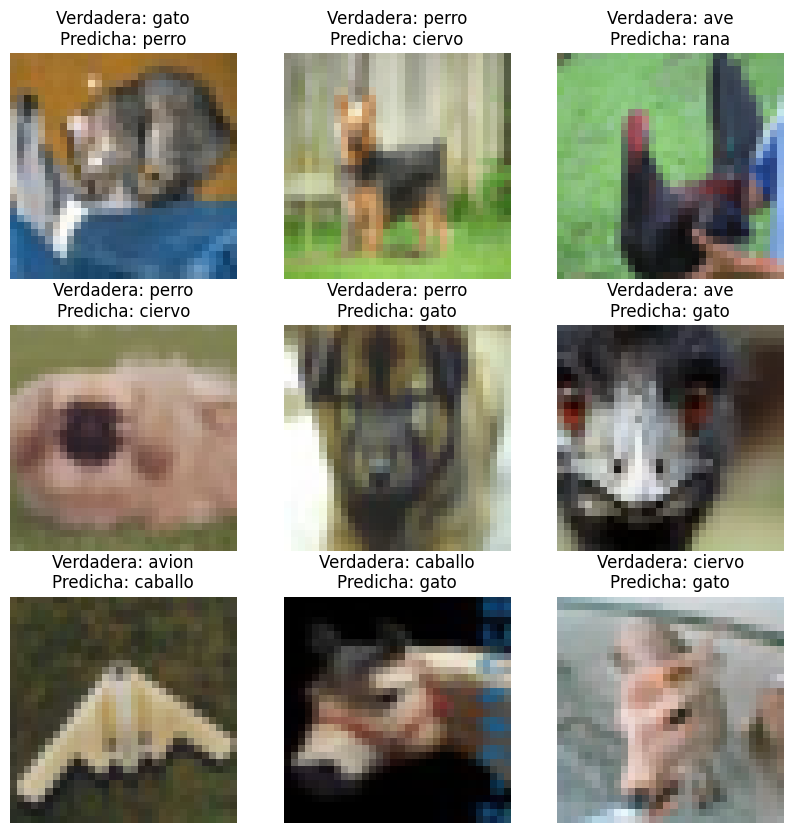

In [ ]:
incorrect_indices = np.where(y_pred_classes != y_true)[0]  # Encuentro índices de predicciones incorrectas

# Muestro algunas imágenes incorrectas
def plot_incorrect_predictions(indices, num=9):
    plt.figure(figsize=(10,10))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(3,3,i+1)
        plt.imshow(x_test[idx])
        plt.title(f"Verdadera: {MAP_ELEMENTS[y_true[idx]]}\nPredicha: {MAP_ELEMENTS[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.show()

plot_incorrect_predictions(incorrect_indices)

### **Conclusiones**

El primer modelo entrenado utilizando una CNN básica obtuvo un rendimiento global del 78.5% de precisión en el conjunto de test, lo cual representa una buena base para futuros ajustes. Estos son los principales resultados obtenidos:

- La curva de pérdida y precisión muestra un progreso consistente con un ligero sobreajuste.
- El modelo podría beneficiarse de ajustes en la regularización dado que la pérdida del conjunto de validación se estabiliza hacia el final del entrenamiento.
- Los vehículos lograrón los mejores resultados en general.
- El análisis visual muestra que las confusiones suelen ocurrir entre clases con características visuales similares como "perro" y "gato", lo que indica que el modelo necesita captar mejor los detalles finos.

Ajustes que podrían mejorar los resultados del modelo:

- Regularización: Introducir técnicas como Dropout o Batch Normalization para reducir el sobreajuste y estabilizar el aprendizaje.
- Optimización de hiperparámetros: Ajustar la tasa de aprendizaje, número de filtros y tamaños de kernel para encontrar una configuración más óptima para el dataset.
- Incrementar el número de épocas para observar si el modelo sigue mejorando o comienza a estancarse.

## **CNN avanzada con BatchNormalization y L2**

Cambios realizados en el modelo, respecto al anterior:

- Se añade una capa convolucional extra.
- Se agrega Batch Normalization.
- Se agrega Regularización L2.
- Se reduce el Dropout.
- Se reduce el Learning rate a 0.0004.
- Aumento a 85 epochs con EarlyStopping menos restrictivo.

**Batch Normalization**: Consiste en normalizar las activaciones de cada capa convolucional o densa usando la media y varianza calculadas a partir de un mini-batch. Esto ayuda a estabilizar y acelerar el entrenamiento, ya que mantiene las distribuciones de las activaciones bajo control. Además, al permitir tasas de aprendizaje más altas y reducir la sensibilidad a la inicialización de pesos, suele llevar a modelos que convergen más rápido y con mejores resultados.

**Regularización L2**: Agrega al loss una penalización proporcional a la suma de los cuadrados de los pesos del modelo. La idea es forzar a que los pesos no crezcan demasiado, ayudando a reducir el overfitting. Cuanto mayor sea el coeficiente de penalización, mayor será la presión para mantener los pesos pequeños.

### **Definición del modelo**

In [ ]:
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l2

def cnn_avanzada(input_shape=(32, 32, 3), num_classes=10, weight_decay=1e-5):
    model = Sequential([

        # Primera capa convolucional con menos filtros para capturar características iniciales
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),           # Se aplica BatchNorm después de la convolución.
        Activation('relu'),             # Es preferible poner la capa de activación en una separada
        MaxPooling2D((2, 2)),
        Dropout(0.25),                  # Reduzco Dropout a 0.25

        # Segunda capa convolucional
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)), # Se agrega l2
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Tercera capa convolucional
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Cuarta capa convolucional
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),  # Aplana la salida de la última capa para poder conectarla a una capa full connected

        # Capa completamente conectada con regularización L2 y Batch Normalization
        Dense(128, kernel_regularizer=l2(1e-3)),   # Aplico un l2 de 1e-3 para esta capa
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),         # Reduzco Dropout a 0.4

        # Capa de salida
        Dense(num_classes, activation='softmax')
    ])
    return model

model_avanz = cnn_avanzada()  # Creo el modelo regularizado
model_avanz.summary()         # Resumen del modelo


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 523,338 (2.00 MB)

 Trainable params: 522,122 (1.99 MB)

 Non-trainable params: 1,216 (4.75 KB)

### **Compilación y entrenamiento**

In [ ]:
model_avanz.compile(optimizer=Adam(learning_rate=0.0004), loss='categorical_crossentropy', metrics=['accuracy']) # Compilo con un learning rate reducido.

# Defino callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)         # Para detener el entrenamiento si hay 20 epochs sin mejoras
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)  # Guardo el mejor modelo durante el entrenamiento

# Entrenamiento del modelo
history_avanz = model_avanz.fit(x_train, y_train_one_hot,
                            epochs=85,                                   # Aumento del número de épocas
                            batch_size=128,                              # Aumento el tamaño del batch
                            validation_data=(x_valid, y_valid_one_hot),
                            callbacks=[early_stop, checkpoint])


Epoch 1/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2596 - loss: 2.3616 - val_accuracy: 0.1320 - val_loss: 3.2414
Epoch 2/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4337 - loss: 1.7629 - val_accuracy: 0.3143 - val_loss: 2.2152
Epoch 3/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4989 - loss: 1.5692 - val_accuracy: 0.4814 - val_loss: 1.6109
Epoch 4/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5519 - loss: 1.4088 - val_accuracy: 0.3847 - val_loss: 2.0242
Epoch 5/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5866 - loss: 1.2928 - val_accuracy: 0.5915 - val_loss: 1.2732
Epoch 6/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6058 - loss: 1.2138 - val_accuracy: 0.6453 - val_loss: 1.0852
Epoch 7/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6289 - loss: 1.1428 - val_accuracy: 0.5840 - val_loss: 1.2936
Epoch 8/85
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6591 - loss: 1.0748 - val_accu

### **Gráficas de precisión y pérdida durante el entrenamiento**

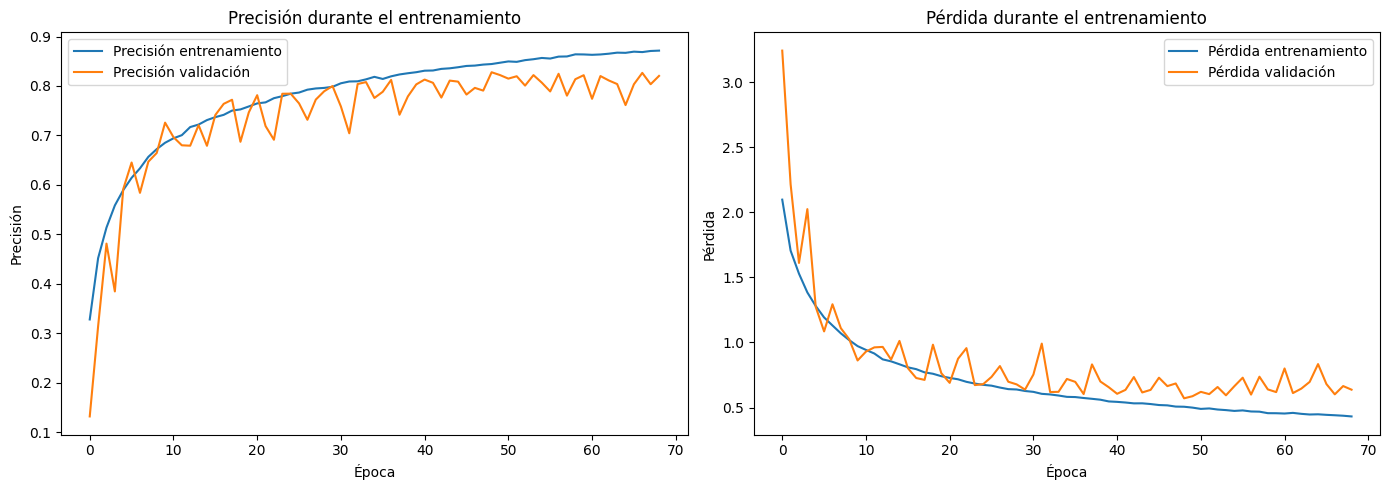

In [ ]:
# Gráfica de precisión y pérdida durante el entrenamiento
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Precisión
    axs[0].plot(history.history['accuracy'], label='Precisión entrenamiento')
    axs[0].plot(history.history['val_accuracy'], label='Precisión validación')
    axs[0].set_title('Precisión durante el entrenamiento')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()

    # Pérdida
    axs[1].plot(history.history['loss'], label='Pérdida entrenamiento')
    axs[1].plot(history.history['val_loss'], label='Pérdida validación')
    axs[1].set_title('Pérdida durante el entrenamiento')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Pérdida')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_training_history(history_avanz)


### **Análisis de resultados**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


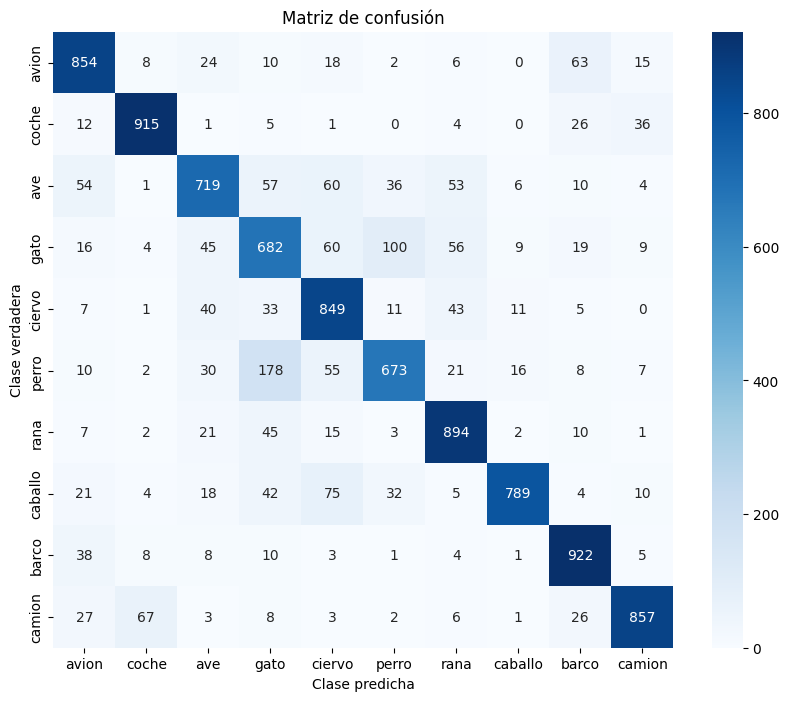

              precision    recall  f1-score   support

       avion       0.82      0.85      0.83      1000
       coche       0.90      0.92      0.91      1000
         ave       0.79      0.72      0.75      1000
        gato       0.64      0.68      0.66      1000
      ciervo       0.75      0.85      0.79      1000
       perro       0.78      0.67      0.72      1000
        rana       0.82      0.89      0.85      1000
     caballo       0.94      0.79      0.86      1000
       barco       0.84      0.92      0.88      1000
      camion       0.91      0.86      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
# Cargo el mejor modelo
best_model = keras.models.load_model('best_model.keras')

# Predicciones y etiquetas verdaderas
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=MAP_ELEMENTS.values(),
            yticklabels=MAP_ELEMENTS.values())
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=MAP_ELEMENTS.values())
print(class_report)

El modelo ha mejorado significativamente el desempeño general de todas las clases, pero sigue teniendo dificultades con algunas como "gato", "ave" y "perro", que presentan una precisión y recall relativamente más bajos en comparación con las demás clases.

### **Análisis de errores**

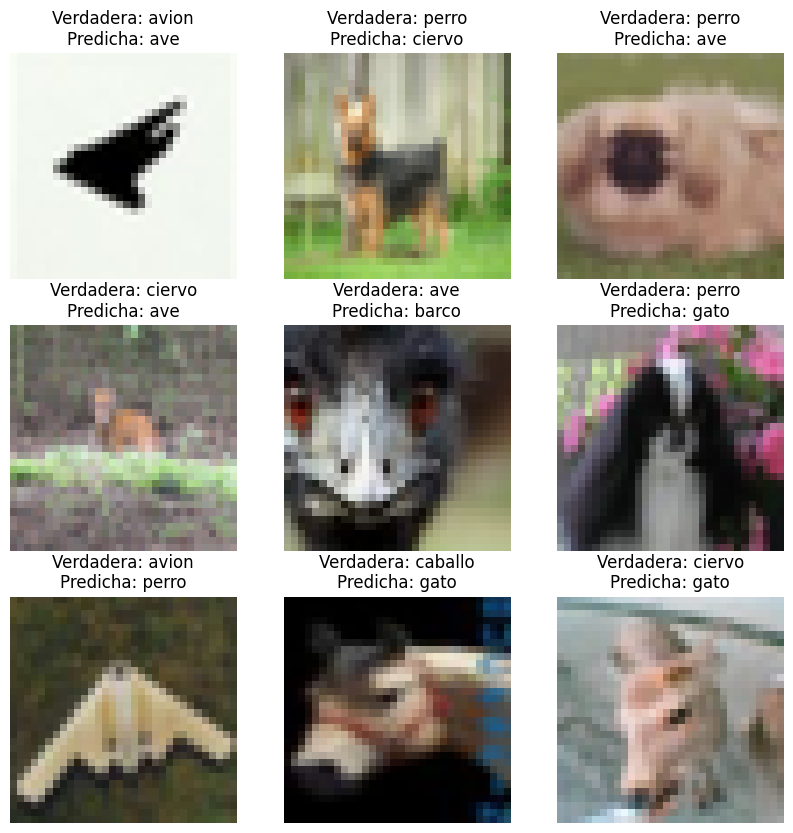

In [ ]:
incorrect_indices = np.where(y_pred_classes != y_true)[0]  # Encuentro índices de predicciones incorrectas

# Muestro algunas imágenes incorrectas
def plot_incorrect_predictions(indices, num=9):
    plt.figure(figsize=(10,10))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(3,3,i+1)
        plt.imshow(x_test[idx])
        plt.title(f"Verdadera: {MAP_ELEMENTS[y_true[idx]]}\nPredicha: {MAP_ELEMENTS[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.show()

plot_incorrect_predictions(incorrect_indices)

### **Conclusiones**

El modelo avanzado supera por 4–5 puntos porcentuales al modelo de CNN básico anterior (de ~78% a ~82–83%). Esto indica que las modificaciones realizadas mejoraron la capacidad del modelo para generalizar y manejar datos complejos.

- Mientras que la CNN básica sólo utilizaba dropout, el modelo avanzado combina varias estrategias de regularización: dropout, BatchNormalization y regularización L2, lo que contribuye a reducir el sobreajuste sin dificultar excesivamente el aprendizaje.
- El uso de más filtros en las capas convolucionales permite capturar características más detalladas de las imágenes, resultando en un rendimiento no solo más alto, sino también más consistente.
- El cambio en la tasa de aprendizaje (de 0.001 a 0.0004) y un Dropout un poco más bajo en las capas convolucionales ha permitido un entrenamiento más fino en cada bloque convolucional.
- Un entrenamiento más prolongado con un mayor número de épocas (con mayor paciencia en EarlyStopping) deja que el modelo avanzado converja más, aprovechando la potencia de la red con más filtros.


Ajustes que podrían mejorar los resultados del modelo:

- Añadir Data Augmentation: Implementar técnicas de aumento de datos como rotaciones, recortes, zooms y ajustes de brillo puede mejorar la capacidad del modelo para generalizar, especialmente en clases con confusiones frecuentes.
- Incorporar Learning Rate Scheduler: Permitirá ajustar dinámicamente la tasa de aprendizaje cuando la red deje de mejorar.
- Ajustar aún más la regularización: Bajar un poco la L2 o quitarla de las capas convolucionales y subir ligeramente el dropout si la red se empieza a sobreajustar. O al revés, reducir un poco el dropout si todavía la red no llega a sobreajustar. El objetivo es encontrar el equilibrio perfecto.
- Incrementar el número de épocas para observar si el modelo sigue mejorando o comienza a estancarse.

## **CNN superior con Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de data augmentation para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=15,              # Rotaciones aleatorias de hasta 15 grados
    width_shift_range=0.1,          # Desplazamientos horizontales aleatorios de hasta un 10% del ancho de la imagen.
    height_shift_range=0.1,         # Desplazamientos verticales aleatorios de hasta un 10% del ancho de la imagen.
    horizontal_flip=True,           # Volteo horizontal aleatorio de las imágenes.
    fill_mode='nearest'             # Rellena los píxeles vacíos tras transformaciones usando el píxel más cercano.
)

# Configuración del generador para el conjunto de validación
val_datagen = ImageDataGenerator()  # No se aplica ninguna transformación a las imágenes del conjunto de validación.
                                    # Las imágenes de validación deben reflejar fielmente el conjunto de datos real, por lo que no deben modificarse para garantizar evaluaciones precisas.

# Creación del generador de datos para el entrenamiento
train_generator = train_datagen.flow(
    x_train,
    y_train_one_hot,
    batch_size=128,                 # Tamaño del lote de datos.
    shuffle=True                    # Las imágenes se mezclan aleatoriamente para evitar que el modelo aprenda patrones específicos del orden.
)

# Creación del generador de datos para la validación
val_generator = val_datagen.flow(
    x_valid,
    y_valid_one_hot,
    batch_size=128,
    shuffle=False                   # No se mezclan las imágenes para conservar el orden original.
)

### **Definición del modelo**

In [ ]:
def cnn_superior(input_shape=(32, 32, 3), num_classes=10, weight_decay=1e-5):
    model = Sequential([

        # Primera capa convolucional con menos filtros para capturar características iniciales
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),           # Se aplica BatchNorm después de la convolución.
        Activation('relu'),             # Es preferible poner la capa de activación en una separada
        MaxPooling2D((2, 2)),
        Dropout(0.2),                             # Reduzco a 0.2

        # Segunda capa convolucional
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)), # Se agrega l2
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),                             # Reduzco a 0.2

        # Tercera capa convolucional
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),                             # Reduzco a 0.2

        # Cuarta capa convolucional
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),                             # Reduzco a 0.2

        Flatten(),  # Aplana la salida de la última capa para poder conectarla a una capa full connected

        # Capa completamente conectada con regularización L2 y Batch Normalization
        Dense(128, kernel_regularizer=l2(1e-3)),   # Aplico un l2 de 1e-3 para esta capa
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),                              # Reduzco a 0.3

        Dense(num_classes, activation='softmax')
    ])
    return model

model_sup = cnn_superior()
model_sup.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 523,338 (2.00 MB)

 Trainable params: 522,122 (1.99 MB)

 Non-trainable params: 1,216 (4.75 KB)

### **Compilación y entrenamiento**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_sup.compile(                        # Compilo el modelo.
    optimizer=Adam(learning_rate=0.001),  # Aumento el learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Defino Callbacks: EarlyStopping, ModelCheckpoint y ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)           # Parada temprana
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)    # Guarda los mejores resultados
reduce_lr = ReduceLROnPlateau(                                                                   # Control dinámico del learning rate
    monitor='val_loss',  # también puedes usar 'val_accuracy'
    factor=0.8,
    patience=5,
    min_lr=1e-6
)

# Entrenamiento del modelo
history_sup = model_sup.fit(
    train_generator,
    epochs=100,                     # Aumento a 100 epochs
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.3262 - loss: 2.1244 - val_accuracy: 0.1372 - val_loss: 3.2693 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.4986 - loss: 1.5468 - val_accuracy: 0.4084 - val_loss: 1.8292 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.5621 - loss: 1.3393 - val_accuracy: 0.6236 - val_loss: 1.1839 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.6020 - loss: 1.2142 - val_accuracy: 0.6157 - val_loss: 1.2483 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.6270 - loss: 1.1375 - val_accuracy: 0.5976 - val_loss: 1.2980 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.6473 - loss: 1.0693 - val_accuracy: 0.6114 - val_loss: 1.1954 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.6

### **Gráficas de precisión y pérdida durante el entrenamiento**

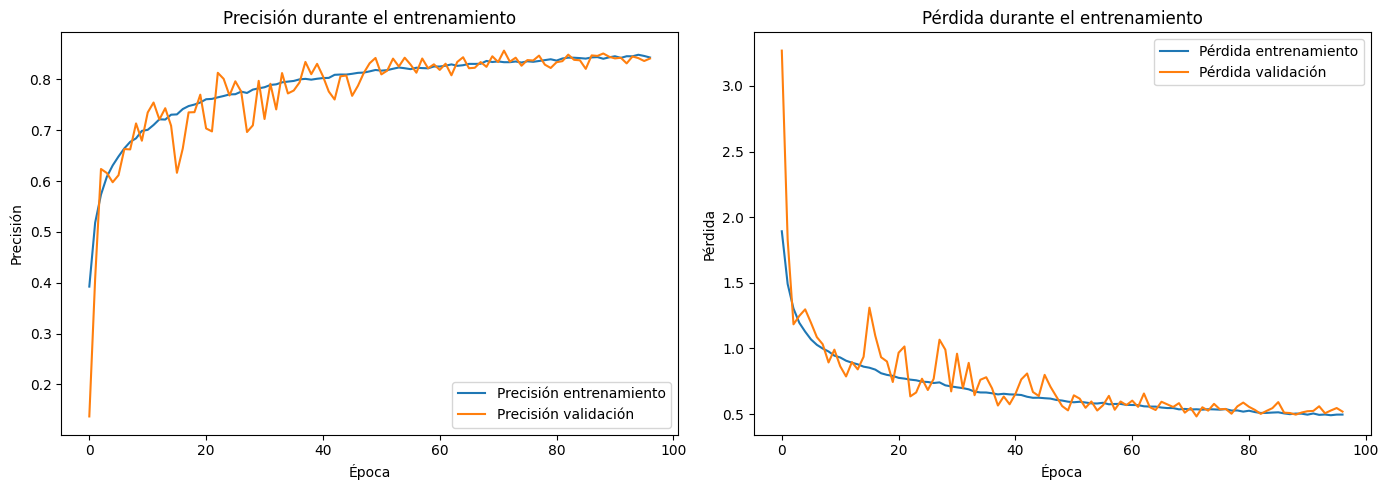

In [ ]:
# Gráfica de precisión y pérdida durante el entrenamiento
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Precisión
    axs[0].plot(history.history['accuracy'], label='Precisión entrenamiento')
    axs[0].plot(history.history['val_accuracy'], label='Precisión validación')
    axs[0].set_title('Precisión durante el entrenamiento')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()

    # Pérdida
    axs[1].plot(history.history['loss'], label='Pérdida entrenamiento')
    axs[1].plot(history.history['val_loss'], label='Pérdida validación')
    axs[1].set_title('Pérdida durante el entrenamiento')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Pérdida')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_training_history(history_sup)


### **Análisis de resultados**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


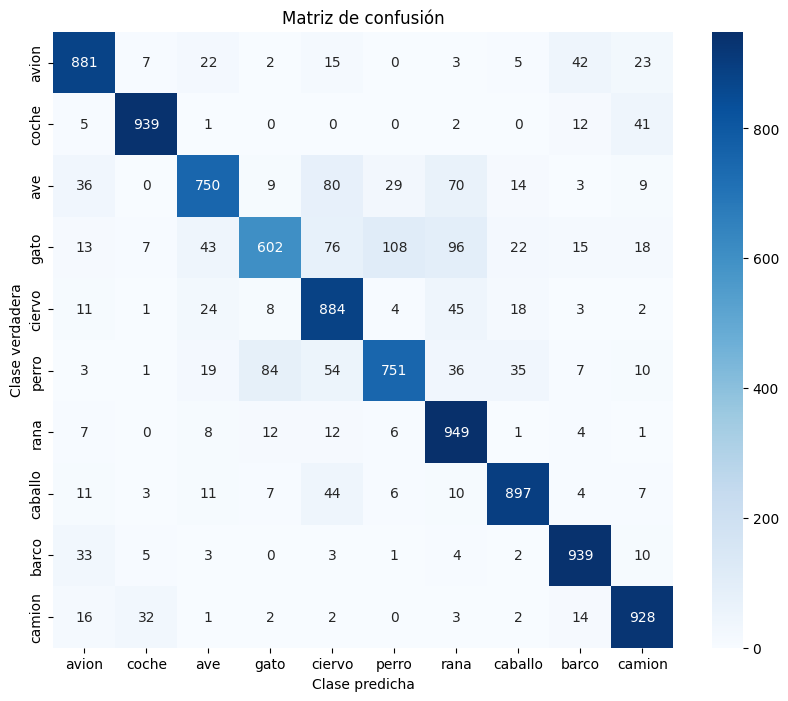

              precision    recall  f1-score   support

       avion       0.87      0.88      0.87      1000
       coche       0.94      0.94      0.94      1000
         ave       0.85      0.75      0.80      1000
        gato       0.83      0.60      0.70      1000
      ciervo       0.76      0.88      0.81      1000
       perro       0.83      0.75      0.79      1000
        rana       0.78      0.95      0.86      1000
     caballo       0.90      0.90      0.90      1000
       barco       0.90      0.94      0.92      1000
      camion       0.88      0.93      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
# Cargo el mejor modelo
best_model = keras.models.load_model('best_model.keras')

# Predicciones y etiquetas verdaderas
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=MAP_ELEMENTS.values(),
            yticklabels=MAP_ELEMENTS.values())
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=MAP_ELEMENTS.values())
print(class_report)


### **Análisis de errores**

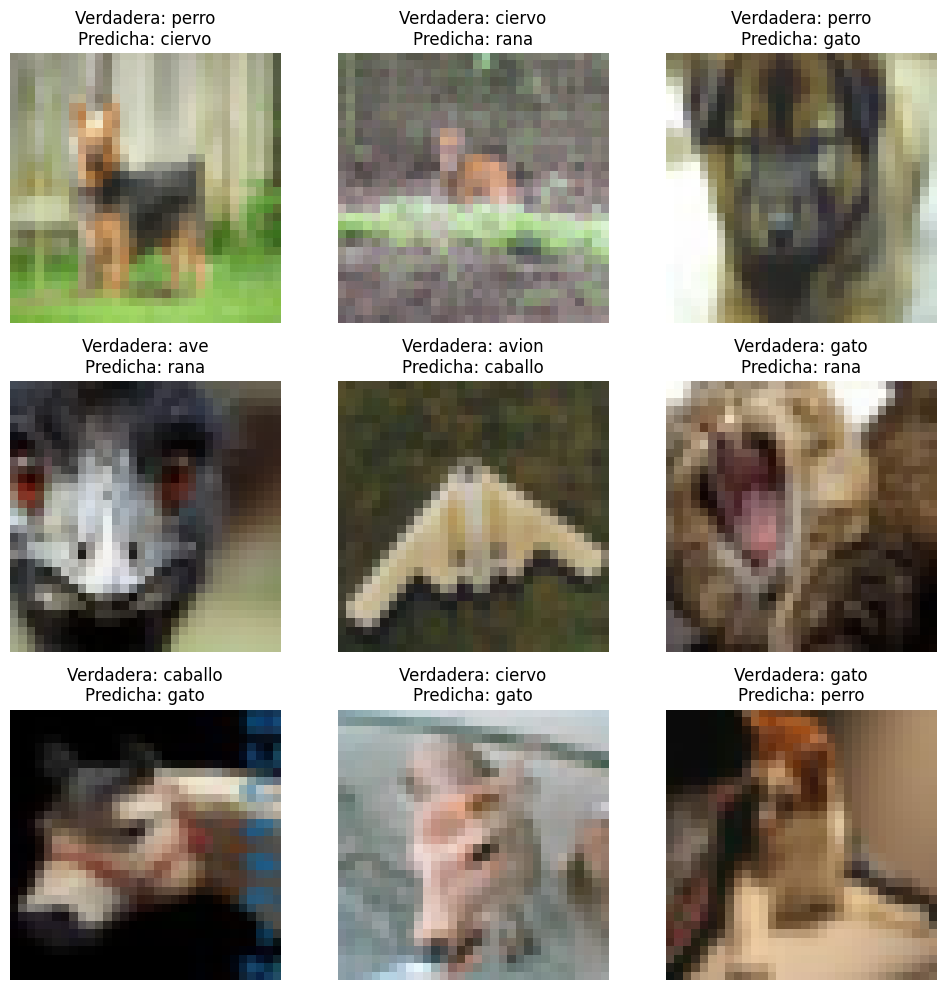

In [ ]:
incorrect_indices = np.where(y_pred_classes != y_true)[0]  # Encuentro índices de predicciones incorrectas

# Muestro algunas imágenes incorrectas
def plot_incorrect_predictions(indices, num=9):
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices[:num]):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_test[idx])
        plt.title(f"Verdadera: {MAP_ELEMENTS[y_true[idx]]}\nPredicha: {MAP_ELEMENTS[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_incorrect_predictions(incorrect_indices)


### **Conclusiones**

El modelo superior logra superar la barrera del 83% que se consiguió en el modelo previo. Este incremento se debe principalmente a la aplicación de data augmentation (rotaciones, traslaciones, flips) y a un ajuste más fino de hiperparámetros (dropout reducido, learning rate inicial mayor y un scheduler que lo reduce gradualmente, etc).

- Con una regularización excesiva (dropout muy alto), el modelo no explotaba toda su capacidad de aprendizaje. La disminución del dropout ha permitido aprovechar mejor la variabilidad de las nuevas imágenes.
- Al aumentar el learning rate inicial a 0.001, el entrenamiento comienza con actualizaciones más enérgicas, ganando precisión de forma rápida. Luego, el scheduler reduce la tasa cuando deja de mejorar la val_loss, ayudando a ajustar los pesos y evitando estancarse.
- Con data augmentation, el modelo necesita ver muchas muestras variadas. Por ello, se buscó entrenar más épocas para así dar margen suficiente para conseguir converger a un buen punto.
- Se puede observar en los resultados del entrenamiento y en las gráficas de precisión y pérdida como este modelo ha conseguido reducir el overfitting aún más respecto a los modelos previos.
- Considero que obtener un ~85–86% en CIFAR-10 con una CNN de tamaño moderado es un logro considerable. Para avanzar hacia 87–88% o más, habría que seguir afinando hiperparámetros o utilizar arquitecturas más profundas (tipo ResNet, VGG, etc.).

## **Comparativa y conclusiones finales**

Recopilación de versiones:

| **Modelo**       | **Capas Conv** | **Dropout**    | **Epochs** | **Overfitting** | **Batch Norm** | **Regularización L2** | **Data Aug** | **Precisión en Test** | **F1-Score Macro** | **Mejores Clases**      | **Peores Clases**      |
|-------------------|----------------|----------------|------------|-----------------|----------------|------------------------|------------------------|-----------------------|--------------------|------------------------|-----------------------|
| **CNN básica**    | 3              | (0.3, 0.5)     | 50     | Ligero      | No             | No                     | No                     | **78.5%**             | 0.78               | Coche, Barco, Camión    | Gato, Ave, Perro      |
| **CNN avanzada**  | 4              | (0.25, 0.4)    | 85     | Leve        | Sí             | Sí                     | No                     | **82.8%**             | 0.82               | Coche, Barco, Camión    | Gato, Perro, Ave      |
| **CNN superior**  | 4              | (0.2, 0.3)     | 100   | Mínimo      | Sí             | Sí                     | Sí                     | **85.6%**             | 0.85               | Coche, Barco, Camión    | Gato, Perro, Ave      |


- **Modelo CNN básica (~78-79% de precisión)**

    Características: Tres bloques convolucionales con 32, 64 y 128 filtros, dropout ~0.3 en cada bloque y 0.5 en la capa densa, sin BatchNormalization ni regularización L2.

    Pros: Modelo sencillo de comprender y entrenar.

    Contras: Queda algo limitado en capacidad y regularización; no llega a una accuracy muy alta.

- **Modelo CNN avanzada (~82–83% de precisión)**

    Características: Cuatro bloques convolucionales (32, 64, 128 y 256 filtros), uso de BatchNormalization y L2, dropout ajustado, entrenado durante más épocas. Sin data augmentation.

    Ventajas: Incremento notorio de exactitud frente al primer modelo, gracias a mayor capacidad, Batch Normalization y mejor equilibrio de regularización.

    Limitación: Aunque BatchNormalization y L2 ya dan un gran salto, puede mejorarse al aplicar augmentation.

- **Modelo CNN superior (~85–86% de precisión)**

    Características: Arquitectura similar al modelo anterior, pero añade data augmentation y reduce dropout, iniciando con un learning rate mayor (0.001). Incluye también un scheduler que baja progresivamente el Learning Rate cuando no hay mejora.

    Logro: Rompe la barrera del 83%, llegando a ~85–86%. Esto demuestra la importancia de data augmentation y un ajuste fino de hiperparámetros en la mejora del rendimiento.


**Conclusión final**

Se ha podido ver cómo, con el mismo core de arquitectura, la precisión va escalando conforme se van ajustando los hiperparámetros y se introducen técnicas como Batch Normalization, Regularización L2, data augmentation, etc.

Para ir aún más lejos (87–88%+), se requeriría seguir ajustando hiperparámetros y/o optar por arquitecturas más profundas o específicas (VGG, ResNet, etc.) y mantener un data augmentation cuidadoso. Aun así, los resultados ya muestran una clara progresión entre los tres modelos y demuestran la importancia de cada técnica aplicada.